## L1 robustness simulations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# simulation parameters
import simulate_loglinear as ll

# seed for random numbers
seed = 42
np.random.seed(seed)
n, p = 100, 50
train_fraction = 0.8 # fraction of data used to fit the model
uncorrelated_fraction = 0.5 # fraction of features which will be uncorrelated with the outcome

X, y, pis, is_correlated = ll.simulate_ll(n, p, uncorrelated_fraction,
                                          seed=seed, verbose=True)
train_ixs = ll.split_train_test(n, train_fraction, seed=seed, verbose=True)

X_train, X_test = X[train_ixs], X[~train_ixs]
y_train, y_test = y[train_ixs], y[~train_ixs]

Number of informative features: 25
Number of uninformative features: 25
Train samples: 80, test samples: 20


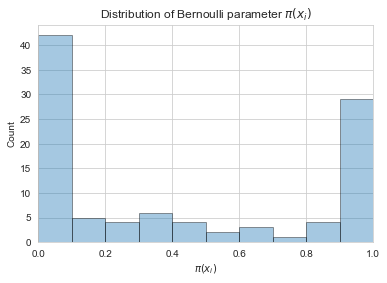

In [3]:
# plot Bernoulli parameter distribution
sns.set_style('whitegrid')
sns.distplot(pis, hist_kws={'edgecolor': 'black'}, kde=False, bins=10)
plt.xlim(0.0, 1.0)
plt.xlabel('$\pi(x_i)$')
plt.ylabel('Count')
plt.title('Distribution of Bernoulli parameter $\pi(x_i)$')
plt.show()

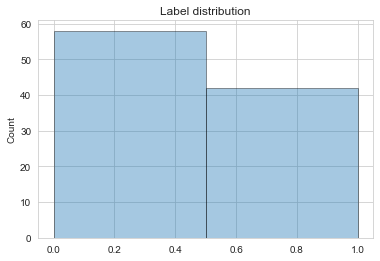

In [4]:
# plot label distribution
sns.distplot(y, hist_kws={'edgecolor': 'black'}, kde=False, bins=2)
plt.ylabel('Count')
plt.title('Label distribution')
plt.show()

Now, let's test how well logistic regression can predict the outcome.

In [5]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')
# clf = LogisticRegression(random_state=seed, penalty='none', solver='lbfgs')
clf.fit(X_train, y_train)
print('Sklearn train accuracy: {:.3f}'.format(clf.score(X_train, y_train)))
print('Sklearn test accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Sklearn train accuracy: 0.988
Sklearn test accuracy: 0.750


In [6]:
import sys; sys.path.append('..')
import config as cfg
from utilities.classify_pytorch import TorchLR

def calculate_accuracy(y, y_pred):
    return np.linalg.norm([1 for i in range(len(y)) if y[i] == y_pred[i]], ord=0) / len(y)

params_map = {
    'learning_rate': [1e-2],
    'batch_size': [50],
    'num_epochs': [200],
    'l1_penalty': [0.01]
}

torch_model = TorchLR(params_map, seed=2)
losses, preds, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test)
y_pred_train, y_pred_test = preds_bn
print('Torch train accuracy: {:.3f}'.format(calculate_accuracy(y_train, y_pred_train.flatten())))
print('Torch test accuracy: {:.3f}'.format(calculate_accuracy(y_test, y_pred_test.flatten())))

Torch train accuracy: 0.975
Torch test accuracy: 0.800


In [9]:
y_train

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])

In [10]:
preds_bn[0].flatten()

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])